# Проект для «Викишоп»

**Описание проекта**

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Описание данных**

* `text` — в нём содержит текст комментария;

* `toxic` — целевой признак.

## Подготовка

Импорт библиотек.

In [1]:
# LinAlg
import numpy as np

# Tables
import pandas as pd
pd.set_option('max_colwidth', 400)

# Visual
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import seaborn as sns
sns.set_style('whitegrid')

# RegExp
import re
from tqdm import notebook

# Lemmatization
import simplemma as smp
langdata = smp.load_data('en')

# NLTK
import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Kirill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Импорт данных.

In [2]:
PATH = '/datasets/toxic_comments.csv'

try:  # local import
    df = pd.read_csv(f'.{PATH}')
except:  # import from Praktikum server
    df = pd.read_csv(PATH)

```python
# Предобработанный датасет
df = pd.read_csv('./datasets/toxic_comments_preprocessed.csv')
```

### Анализ

Взглянем на данные.

In [3]:
def cls_balance(df, row):
    '''
    Displays target class balance using Pyplot bar plot.
    '''
    green = (0.5529411764705883, 0.8274509803921568, 0.7803921568627451)
    red = (0.984313725490196, 0.5019607843137255, 0.4470588235294118)

    bal = df.groupby(row).agg({row: 'count'})
    bars = plt.bar(range(2), bal[row], color=[green, red])

    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x()+bar.get_width() / 2, h, str(h)+' (%.2f%%)' %
                 (h/len(df)*100), ha='center', va='bottom')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks([0, 1])
    plt.title('Баланс классов целевого признака')
    plt.xlabel('Значение класса')
    plt.ylabel('Частота класса')
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


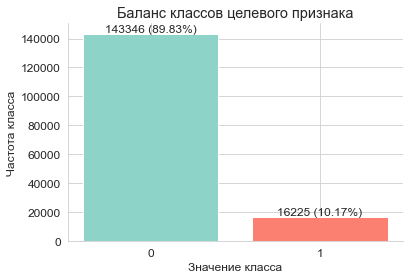

,text,toxic
97671,"""I WILL BE ALLOWED TO ANSWER THIS CHARGE...Clown, this the real JOE, and I never owned a red pickup truck, Considering you live on a very busy county road, you would get """"Red trucks"""" roll by from time to time. Further more finding out who you are is very easy, since your have a very """"PUBLIC"""" presence on the INTERNET and a google search on your name, beer, and Wilber yields the answer, The ...",1
41738,The questioned editor here is in fact aware of this discussion as per user's talk page. \n\nRe: latest 2-part comment in very good faith: there have long been perfectly clear established facts about all this in very reliable literature that need no further discussion nor any reevaluation by Wikipedia. I go by Burke's and Debrett's in English. Respectfully suggest we all save ourselves the trou...,0
65509,Asperger's Syndrome and You \n\nYour edit history and discussion page remarks suggest the strong possibility that you suffer from Asperger's Syndrome. Less sperging will lead to a longer and happier life.,0
152152,"""\n\nApology\nI would like to apologize for this comment, particually the last line where I said that Damiens.rf should be hung for his behavior. Did I mean for him to literally be hung from a gallows? No. Will it happen again? No. Why? I am taking myself out of this discussion, because it is getting me riled up to the point that I am saying things I obviously don't mean and getting righ...",0
32076,"07:40, 22 November 2005",0


In [4]:
df.info()
cls_balance(df, 'toxic')
display(df.sample(5))

Посмотрим отдельный пример комментария.

In [5]:
display(df.loc[63009, 'text'])
print('Toxic:', df.loc[63009, 'toxic'])

"Where have you seen any personal attacks? You just personally prefer to offend me. What can I do about it? I don't know. And yes I don't want to continue any conversations with ignorant mazapukers. Poor those people who discussed that with you and similar to you. I understand them very well. Are you so unintellegent mazapuker? Have you ever thought if there won't be any problem you would never see me here Ukrainian a citizen of Ukraine and a resident of Kyiv telling you that? Like African American that trying to make someone to stop calling him N. Very sad you are not liberal enough to understand that. It is inevitable but your conservative mind wants to stop it. Everything changes. After your death (if Wikipedia will exist) it for sure will be Kyiv and you won't exist by that time and couldn't change it. Why are you trying to stop things which you cannot change? What kind of perversion is it? 94.244.129.207"

Toxic: 0


* Корпус текста состоит из 159571 объектов, выделим 10% на валидацию;
* Комментарии на разговорном письменном английском, содержат сокращения с апострофами;
* Данные размечены не идеально, есть токсичные комментарии не отмеченные флагом.
* Баланс классов смещен в пользу нейтральных комментариев в соотношении 9 к 1;
> Если ML-модель сделает предсказание, в котором все комментарии будут отнесены к нейтральным, то это даст 89,83% точности (Accuracy), поэтому мы будем использовать оценку F1 в качестве метрики.
* Объекты содержат спецсимвол `\n` после импорта;
* Отсутствуют пропуски и дубликаты.

### Предобработка

Заведём словарь для разворачивания слов с апострофами, и набор функций для подготовки корпуса к обучению.

In [6]:
contractions_dict = {
    "ain't": "are not", "'s": " is", "aren't": "are not", "can't": "cannot",
    "can't've": "cannot have", "‘cause": "because", "could've": "could have",
    "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
    "he'll": "he will", "he'll've": "he will have", "how'd": "how did", "how'd'y": "how do you",
    "how'll": "how will", "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not",
    "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
    "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "that'd": "that would", "that'd've": "that would have", "there'd": "there would",
    "there'd've": "there would have", "they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what've": "what have",
    "when've": "when have", "where'd": "where did", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who've": "who have",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
    "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))

def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

def undo_punct_stop(token):
    return [word for word in token if word.isalpha() and word not in stop_words and len(word) < 20]

def lemmatize(token):
    return [smp.lemmatize(word, langdata) for word in token]

def normalize(text):
    expanded = expand_contractions(text).lower()
    tokenized = word_tokenize(expanded)
    filtered = undo_punct_stop(tokenized)
    lemmatized = lemmatize(filtered)
    
    return lemmatized

* Развернём апострофы → приведём к нижнему регистру → токенизируем → уберем пунктуацию и стоп-слова → лемматизируем;

```python
df['lemm_text'] = df['text'].apply(normalize)
```

* Сохраним результат, чтобы не повторять шаг при перезапуске ядра.

```python
df.to_csv('./datasets/toxic_comments_preprocessed.csv', index=False)
```

## Обучение

Подготовим выборки.

```python
# Data
X, y = df['lemm_text'], df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)
```

### Naive Bayes, Logit, LinearSVC + Bag of words

Возьмем три модели и соберем пайплайн с векторизацией по методу мешка слов. Сравним результаты метрикой F1.

```python
# Models
models = [
    ('Naive Bayes', MultinomialNB()),
    ('Logit',  LogisticRegression(max_iter=1000, random_state=42) ),
    ('Linear SVC', LinearSVC(dual=False, random_state=42) ),
]


# Evaluation
results = []
names = []
for name, model in notebook.tqdm(models):

    pipe = Pipeline([  
        ('tf', TfidfVectorizer(use_idf=False, norm=None)),
        (name, model),
    ])

    cv_results = cross_val_score(
        pipe, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

    results.append(cv_results), names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
    
# visualization
plt.boxplot(results, labels=names)
plt.title('Сравнение алгоритмов')
plt.xlabel('Model')
plt.ylabel('Mean F1 Score')
plt.tight_layout()
plt.show()
```

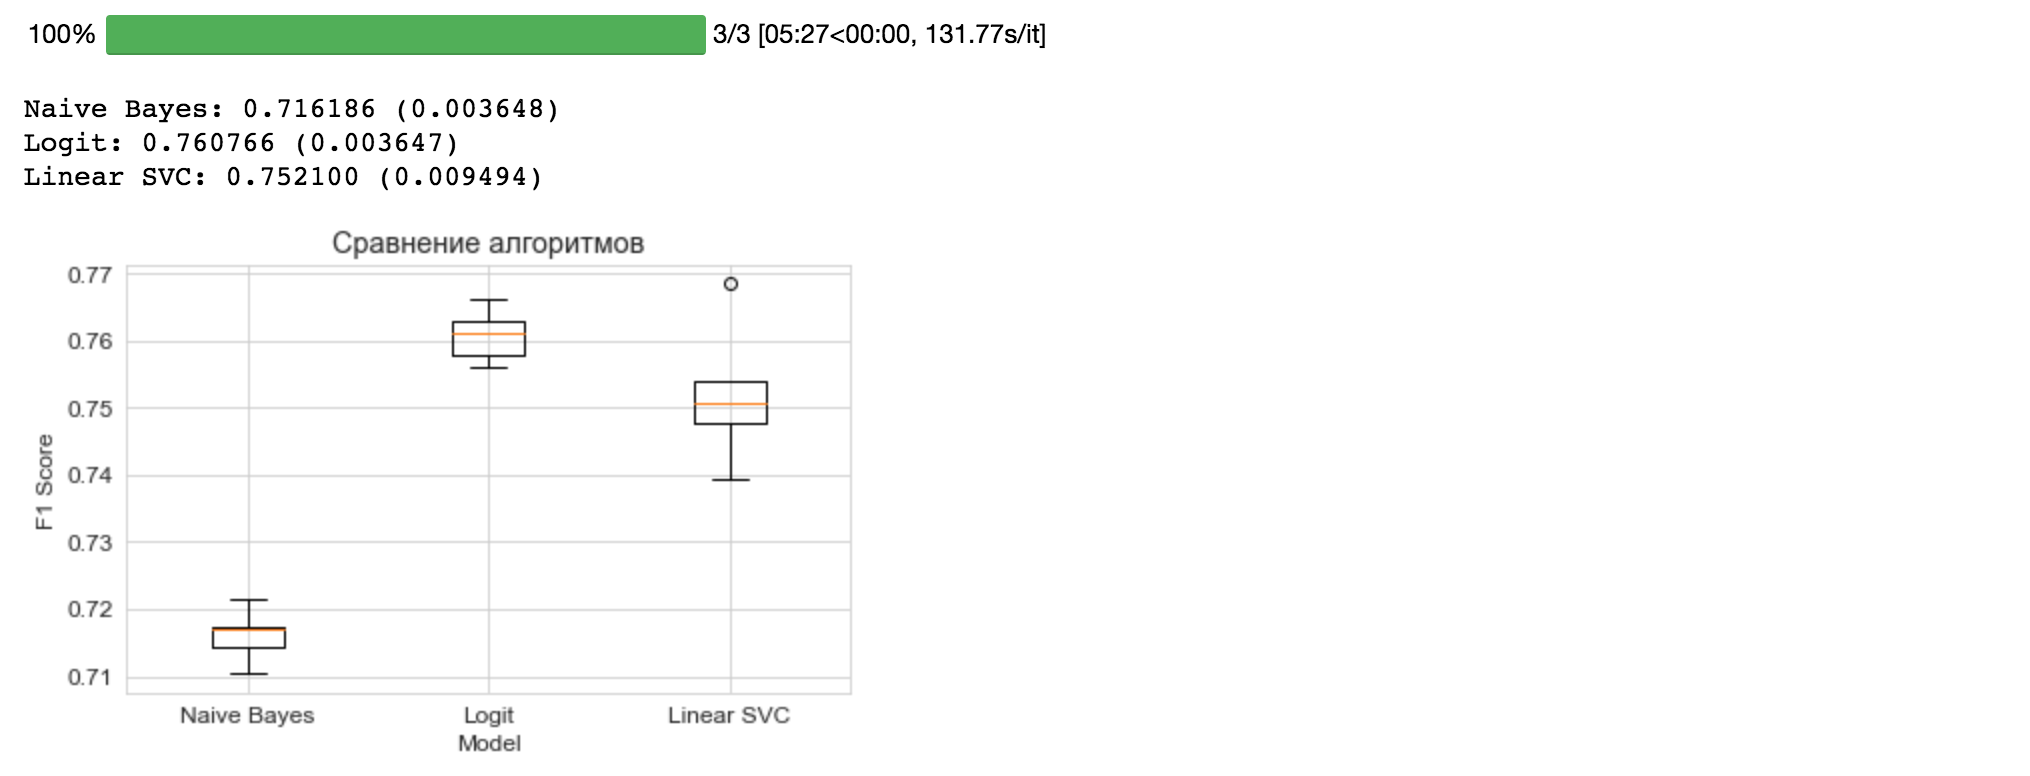

### Logit, LinearSVC + TF-IDF

Возьмем две модели и соберем пайплайн с векторизацией по методу `TF-IDF`. Байеса уберем, он плохо совместим с `TF-IDF`.

```python
# Models
models = [
    ('Logit',  LogisticRegression(max_iter=1000, random_state=42) ),
    ('LinearSVC', LinearSVC(dual=False, random_state=42) ),
]


# Evaluation
results = []
names = []
for name, model in notebook.tqdm(models):

    pipe = Pipeline([  
        ('tfidf', TfidfVectorizer()),
        (name, model),
    ])

    cv_results = cross_val_score(
        pipe, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

    results.append(cv_results), names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
    
# visualization
plt.boxplot(results, labels=names)
plt.title('Сравнение алгоритмов')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()
```

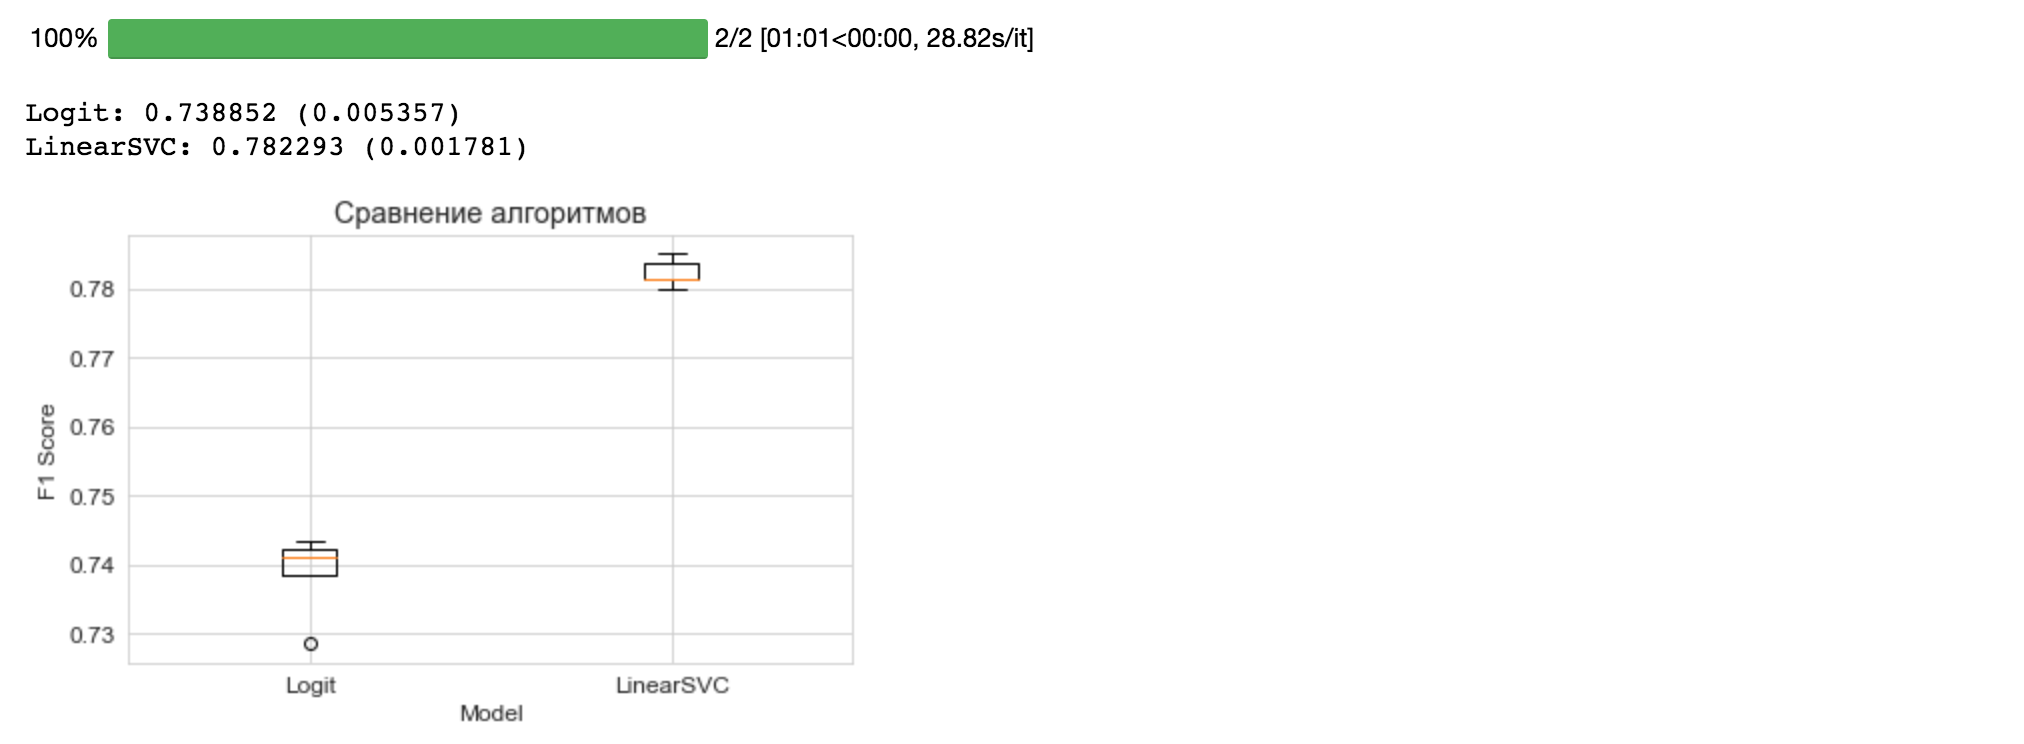

### LinearSVC + TF-IDF + GridSearchCV

Пройдём по сетке и методом кросс-валидации подберем оптимальные гиперпараметры. Оценим эффект балансировки классов.

```python
# Model
model = LinearSVC(dual=False, random_state=42)


# Grid
param_grid = dict(
    clf__C=[0.01, 0.1, 1, 10],
    clf__class_weight=[None, 'balanced'],
)


# Evaluation
pipe = Pipeline([  
    ('tfidf', TfidfVectorizer()),
    ('clf', model),
])

GS = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', verbose=3)
GS.fit(X_train, y_train)
GS.best_params_


# Summary
print('Best F1 Score: %.3f' % GS.best_score_)
print('Config: %s' % GS.best_params_)
```

Лучший проход:

```python
Best F1 Score: 0.782
Config: {'clf__C': 1, 'clf__class_weight': None}
```

### Тестирование

In [7]:
def cf_matrix(true, prediction):
    '''
    Custom interface for the Confusion Matrix output.
    '''
    plt.figure(figsize=(7, 6))

    cf_matrix = confusion_matrix(true, prediction)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
      
    plt.title('Матрица ошибок предсказаний целевого признака')
    plt.tight_layout()
    plt.show()

```python
# Data
tf_idf = TfidfVectorizer()
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

# Train
model = LinearSVC(dual=False, random_state=42)
%time model.fit(X_train_tfidf, y_train)

CPU times: user 3.51 s, sys: 113 ms, total: 3.62 s
Wall time: 1.92 s

# Evaluate
y_pred = model.predict(X_test_tfidf)
print('F1 Score on Test: %.3f' % f1_score(y_test, y_pred))

cf_matrix(y_test, y_pred)
```

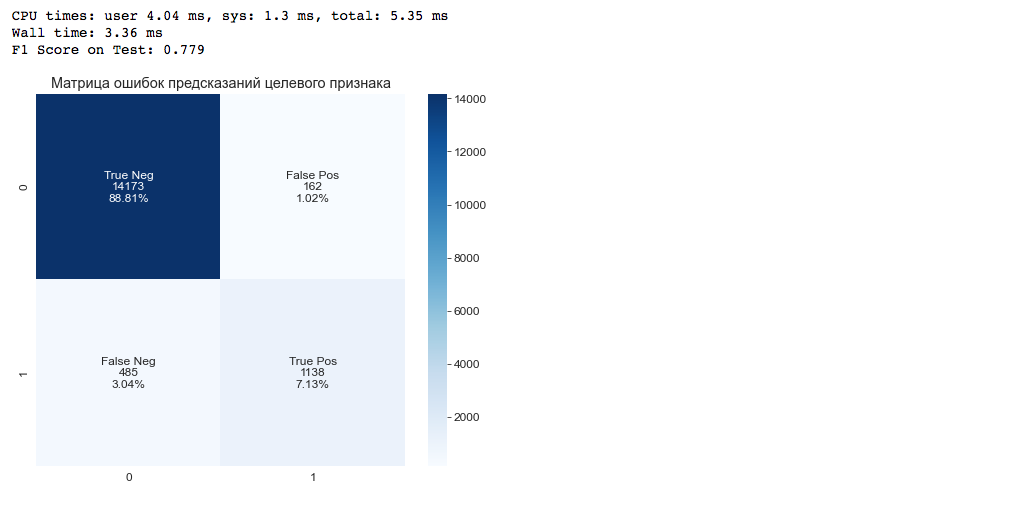

## Вывод

* На вход получен размеченный корпус текста из 159571 объектов, со смещением баланса 9к1 в пользу нейтрального класса;

* Потребовалось провести очистку и векторизацию, чтобы корпус стал пригоден для применения ML;
* Проведен эксперимент с моделями `Naive Bayes`, `Logit` и `SVM`, с техниками векторизации: `Bag of words` и `TF-IDF`;
* Модель `SVM + TF-IDF` показала результат по метрике `F1 равный 0.779`, со скоростью обучения в `1.92 сек`, предсказания `3.36 сек`;
* Модель дает верное предсказание в `95,94%` случаев, пропуская `~30%` токсичных комментариев;
* C помощью нейронных сетей (LSTM, BERT, etc) можно улучшить результат.